### Exercise 8: 

Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

In [6]:
# let's load the dataset we will be using

from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2,3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [12]:
# training the models

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 10
alpha = 1 / (C * len(X))

lin_clff = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clff = SVC(kernel="linear", C=C)
SGD_clff = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clff.fit(X_scaled, y)
svm_clff.fit(X_scaled, y)
SGD_clff.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clff.intercept_, lin_clff.coef_)
print("SVC:                         ", svm_clff.intercept_, svm_clff.coef_)
print("SGDClassifier(alpha={:.3f}):".format(SGD_clff.alpha), SGD_clff.intercept_, SGD_clff.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.001): [0.117] [[0.77735075 0.73012524]]


let's plot the decision boundaries of these three models



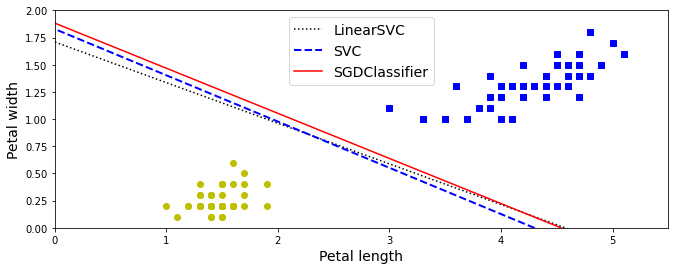

In [13]:
# Compute the slope and bias of each decision boundary
import matplotlib.pyplot as plt

w1 = -lin_clff.coef_[0, 0]/lin_clff.coef_[0, 1]
b1 = -lin_clff.intercept_[0]/lin_clff.coef_[0, 1]
w2 = -svm_clff.coef_[0, 0]/svm_clff.coef_[0, 1]
b2 = -svm_clff.intercept_[0]/svm_clff.coef_[0, 1]
w3 = -SGD_clff.coef_[0, 0]/SGD_clff.coef_[0, 1]
b3 = -SGD_clff.intercept_[0]/SGD_clff.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
first_line = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
second_line = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
third_line = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(first_line[:, 0], first_line[:, 1], "k:", label="LinearSVC")
plt.plot(second_line[:, 0], second_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(third_line[:, 0], third_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

### Exercise 9

Train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?

In [15]:
# loading dataset

import numpy as np

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [18]:
# let's train SVM classifier

lin_clsf = LinearSVC(random_state=42)
lin_clsf.fit(X_train, y_train)

C:\Users\prosp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=42)

In [19]:
# let's make predictions on the training set and measure the accuracy

from sklearn.metrics import accuracy_score

y_pred = lin_clsf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8348666666666666

In [20]:
# let's scale the dataset

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [21]:
# let's train the scaled dataset

lin_clsf = LinearSVC(random_state=42)
lin_clsf.fit(X_train_scaled, y_train)

C:\Users\prosp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(random_state=42)

In [22]:
# let's make predictions on the training set and measure the accuracy

y_pred = lin_clsf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9217333333333333

In [23]:
# let's use an SVM

svm_clsf = SVC(gamma="scale")
svm_clsf.fit(X_train_scaled[:20000], y_train[:20000])

SVC()

In [24]:
# let's make predictions on the training set and measure the accuracy

y_pred = svm_clsf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9627

let's tune the hyperparameters by doing a randomized search with cross validation. We will use a small dataset to speed up the process

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rand_search_cv = RandomizedSearchCV(svm_clsf, param_distributions, n_iter=10, verbose=2, cv=3)
rand_search_cv.fit(X_train_scaled[:2000], y_train[:2000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=10.231847518678256, gamma=0.00324637629156057; total time=   0.8s
[CV] END ....C=10.231847518678256, gamma=0.00324637629156057; total time=   0.9s
[CV] END ....C=10.231847518678256, gamma=0.00324637629156057; total time=   0.8s
[CV] END ......C=9.82735647444345, gamma=0.01953015929944632; total time=   1.1s
[CV] END ......C=9.82735647444345, gamma=0.01953015929944632; total time=   1.0s
[CV] END ......C=9.82735647444345, gamma=0.01953015929944632; total time=   1.0s
[CV] END ....C=2.2185099579719294, gamma=0.07702733120134099; total time=   1.0s
[CV] END ....C=2.2185099579719294, gamma=0.07702733120134099; total time=   1.0s
[CV] END ....C=2.2185099579719294, gamma=0.07702733120134099; total time=   1.0s
[CV] END ....C=7.031527232434906, gamma=0.001955514351315848; total time=   0.6s
[CV] END ....C=7.031527232434906, gamma=0.001955514351315848; total time=   0.6s
[CV] END ....C=7.031527232434906, gamma=0.001955

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019F04019CD0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000019F04034760>},
                   verbose=2)

In [26]:
rand_search_cv.best_estimator_

SVC(C=7.031527232434906, gamma=0.001955514351315848)

In [27]:
rand_search_cv.best_score_

0.8810121966044004

### Exercise 10

Train an SVM regressor on the California housing dataset.

In [29]:
# loading the dataset

from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [30]:
# split the dataset into training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# scale the dataset

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# train a simple LinearSVR 

from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

C:\Users\prosp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVR(random_state=42)

In [35]:
# let's see how it performs on the training set
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.9641780189948642

In [36]:
# rmse

np.sqrt(mse)

0.9819256687727764

In [ ]:
# let's use randomized search with cross validation to find the appropriate hyperparameter values for C and gamma:

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rand_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rand_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  11.8s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  13.3s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  11.3s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  10.8s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  10.6s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  10.6s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  10.7s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  10.5s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  10.6s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  11.7s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  10.3s
[CV] END ....C=1.5808361216819946, gamma=0.05399

In [ ]:
rand_search_cv.best_estimator_

In [ ]:
# let's measure the RMSE on the training set:

y_pred = rand_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

In [ ]:
# let's measure the RMSE on the test set:

y_pred = rand_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)